# Chapter 3 - Camera Projection


In the last chapter, we've seen how a Lens works. In this chapter, we are finding a mathematical model for converting
the (X,Y,Z)-Coordinates of an Object in our world to pixel coordinates (u,v) on an image. 


In this example, (u,v) are pixel coordinates measured from the top-left of an image. The center of our image is the Origin, or
principal point *O*. The focal length *f* is given as well as the Optical Center, e.g. the Center of the Lens *C*.


To convert from World to Pixel coordinates, we have to perform three steps:
- 1. Convert the world point (X,Y,Z) to a new coordinate system that has the cameras Optical Center *C* as the (0,0,0) Origin. We
do that via rigid body transformation, so Rotation R and translation t. 
- 2. Convert the resulting Camera Point to new coordinates in the same coordinate system on the Optical sensor, (x,y,z) using the cameras intrinsic parameter matrix K. The optical sensor is also referred to as "image plane"
- 3. Convert (x,y,z) to pixel coordinates (u,v) by normalizing with z. 

![World and pixel coordinates, p. 50](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_3/1_world_and_pixel_coordinates.png)
*Figure 1: Overview: World Coordinates -> Camera Coordinates -> Image Coordinates -> Pixel Coordinates. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/02_image_formation_1.pdf)*

## From World to Camera


Given world coordinates (Xw, Yw, Zw), we want to find a new coordinates (Xc, Yc, Zc) which is just a new coordinate system
that has the Cameras Principal Point O as the origin point (0, 0, 0). 
This can be done using a rigid body transformation, so a combined rotation R and translation t. 
The matrix [R|t] is called the **Matrix of extrinsic parameters**. 

![World and Camera coordinates, p. 58](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_3/2_world_to_camera_coordinates.png)
*Figure 2: World Coordinates -> Camera Coordinates. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/02_image_formation_1.pdf)*

## From Camera to Image plane


We can map a point from the Camera Coordinate System, Pc = (Xc, Yc, Zc) to the Optical sensor p = (x, y) by using the concept of 
similarity triangles again, with thinking back to the pinhole approximation from the last chapter. 


Let's isolate the cameras x,y dimension and have a look at them seperatly. We see that Pc = (Xc, 0, Zc) projects into p = (x,0). 
We now need to find out the projections x coordinate. 
From the concept of similarity, we see that *x/f = Xc / Zc* must hold. Therefore, we can deduct that **x = fXc / Zc**. 
This also holds for the y-dimenion, of course: **y = fYc / Zc**. 

![Camera to Frame coordinates, p. 58](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_3/3_camera_to_frame_coordinates.png)
*Figure 3: Camera Coordinates -> Image Coordinates. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/02_image_formation_1.pdf)*

## From Camera to Pixel Coordinates
The first step is already done: with **x = fXc / Zc** and **y = fYc / Zc**, we bring the Camera coordinates to Image coordinates.
Now we only have to map them to Pixel coordinates by shifting them from the Origin *O = (u0, v0)* to the top-left (0,0) Pixel. We further introduce
a new parameter *ku* and *kv* that determines the scale of the pixels in both dimensions. We get the following u,v coordinates:


**u = u0 + ku * x**
**v = v0 + ku * y**


In combination with the previous results, we get 


**u = u0 + ku * fXc / Zc**
**v = v0 + ku * fYc / Zc**


We can now bring the point p = (u,v) into the previously seen homogeneous coordinates: p = (u,v) = l*(u,v,1). Expressed in matrix form,
we get 

![Matrix for u,v, p. 53](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_3/4_camera_to_pixel_coordinates.png)
*Figure 4: Camera Coordinates -> Image Coordinates -> Pixel Coordinates. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/02_image_formation_1.pdf)*

This matrix is called K, the **Matrix of intrinsic parameters**, or **calibration matrix**. It defines the internal properties
of the Camera: It's focal length and the resolution, as well as the scewing factors k, which can be assumed to be 1 for modern 
cameras with good build quality.


Given an image resolution of 640x480 Pixels and a focal length of 210 **pixels**, we get a matrix of intrisics:


```
[[ f   0  u0 ],
 [0    f  v0 ],
 [0    0  1  ]]
```
or, with numbers:
```
[[210  0  320],
 [0   210 240],
 [0    0   1 ]]
```


## From World to Pixel Coordinates

We can finally bring it all together by combining the matrix of intrinsics and extrinsics.

![Matrix KRt, p. 58](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_3/5_world_to_pixel_coordinates.png)
*Figure 5: World Coordinates -> Pixel Coordinates. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/02_image_formation_1.pdf)*

## Normalizing the Image Coordinates

Sometimes it can be handy to have a representation with focal length = 1. We can achieve this by an alternative 
representation: 

Since K-1 is just 

```
[[1/f  0   -u0 ],
 [ 0  1/f  -v0 ],
 [ 0   0    1  ]]
```

We can create a normalized system with multiplying (u, v, 1) with K-1. 

![Matrix uv1, p. 59](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_3/6_normalized_image_coordinates.png)
*Figure 6: Normalized Image Coordinates. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/02_image_formation_1.pdf)*

## Python implementation

Now let's start with a simple example in python that demonstrates the conversion from given world
coordinates to pixel coordinates (u, v), given the cameras intrinsics and cameras 3D position relative
to the world origin (0, 0, 0). The position is given by a Rotation matrix R and a translation vector t, while
the cameras intrinsic is given as a matrix K.

We are going through three steps:

- 1. Map the world point Pw (Xw, Yw, Zw) into the camera frame Pc (Xc, Yc, Zc)
- 2. Project the point into the image plane to get normalized coordinates p = (x,y) = (X/Z, Y/Z)
- 3. Apply lens distortion to p to get distorted normalized coordinates p_dist = (u,v) = (1 + kx * r^4 + ky * r^2)(x, y)
with r^2 = (x^2 + y^2)
- 4. Convert the normalized coordinates p_dist to get discretized pixel coordinates (u,v). 

At first, we will not take lens distortion into account. We'll see later in this article how to fix lens distortion.


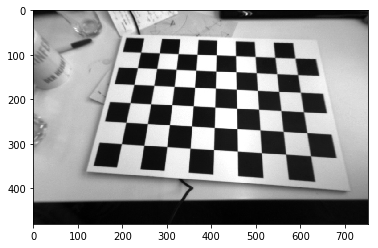

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Cameras intrinsic parameters [K] (f~420px, w~710px, h~500px)
K = np.array(
    [[420.506712, 0.,          355.208298],
     [0.,         420.610940,  250.336787],
     [0.,         0.,          1.]]
)

# Relative camera position [R|t] in respect wo world coordinate system
# Rotatio matrix in radian
R = np.array(
    [[0.9972,   -0.0699,  0.0263],
     [0.0553,    0.9299,  0.3598],
     [-0.0501,  -0.3572,  0.9312]]
)

# Translation vector in meters
t = np.array(
    [[-0.1070],
     [-0.1471],
     [0.3985 ]]
)

# Example image (since we have a greyscale image, reduce dimensionality down to 2)
img = mpimg.imread('img/chapter_3/img_0001.jpg')[:,:,0]
plt.imshow(img, cmap='gray')
plt.show()

Let's write the code to project the origin (X, Y, Z) = (0, 0, 0) from the world coordinate system into the cameras 
pixel coordinates (u, v). 

To do so, let's first craft a matrix T = [R|t], which is just a 3x4 matrix combining the rotation matrix R and 
translation vector t. 


In [2]:
# Transformation matrix T = [R|t]
T = np.concatenate((R, t), axis=1)
T

array([[ 0.9972, -0.0699,  0.0263, -0.107 ],
       [ 0.0553,  0.9299,  0.3598, -0.1471],
       [-0.0501, -0.3572,  0.9312,  0.3985]])

To transform from World coordinates (Xw, Yw, Zw) to the Camera frame (Xc, Yc, Zc), we only need to multiply *T* with 
(X,Y,Z,1). Remember that T is a 3x4 matrix, so to add the translation vector t, we need to add an additional 
component 1 to the world coordinate point.


In [3]:
# Origin in World Coordinate system, located at (X,Y,Z,1) = (0, 0, 0, 1)
Pw = np.array(
    [[0],
     [0],
     [0],
     [1]]
)

# Project (Xw, Yw, Zw, 0) into cameras coordinate system
Pc = np.matmul(T, Pw)

# Apply camera intrinsics to map (Xc, Yc, Zc) to p=(x, y, z)
p = np.matmul(K, Pc)

# Normalize by z to get (u,v,1)
uv = (p / p[2][0])[:-1]
uv

array([[242.29934396],
       [ 95.07488167]])

What we got en return are discrete pixel (u,v) coordinates that we can plot over our image


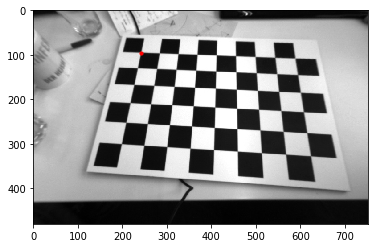

In [4]:
# Plot World origin (0, 0, 0) on images normalized UV-Pixel coordinates
plt.imshow(img, cmap='gray')
plt.scatter(x=uv[0], y=uv[1], c='r', s=10)
plt.show()

We can see very clearly that the origin of the world coordinate system is set to the top-left corner of the chess board.
Let's get a little more fancy and draw a cube into the top-right of the chess board. By measuring the chess board on our table, we can find out that one square is 0.04m x 0.04m in size. As a first step, let's therefore move our point 28cm to the right. To do this, we simply need to redefine our world coordinates to not be (X,Y,Z) = (0, 0, 0), but (0.24, 0, 0). 

Let's also write two quick functions, one that creates a matrix from x,y,z coordinates for the real world, the other transforming it to discrete (u,v) coordinates.


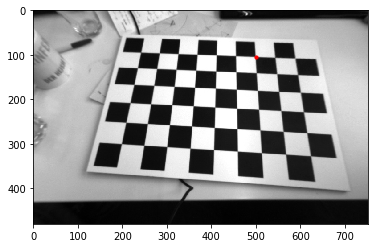

In [5]:
def makeWorldVector(x=0, y=0, z=0):
    """
    Creates a world coordinate vector out of x,y,z components
    :param number x:    x-coordinate of point in meters
    :param number y:    y-coordinate of point in meters
    :param number z:    z-coordinate of point in meters
    :return: Vector in world coordinates
    :rtype: np.array(x, y, z, 1)
    """
    return np.array(
        [[x],
         [y],
         [z],
         [1]]
    )

def worldToPixels(Pw):
    """
    Convers a vector in world coordinates to uv pixel coordinates
    :param np.array(x, y, z, 1) Pw:     World vector 
    :return: (u,v) pixel coordinates of world point in image frame
    :rtype: Tuple[number, number]
    """
    Pc = np.matmul(T, Pw)
    Pc_norml = (Pc / Pc[2][0])
    p = np.matmul(K, Pc_norml)
    uv = p[:-1]
    return uv[0], uv[1]

def plotPoints(us, vs):
    """
    Plots a list of pixel coordinates on an image
    :param List[number] us:     List of u-coordinates for scatter plot points
    :param List[number] vs:     List of v-coordinates for scatter plot points
    :return: None
    """
    plt.imshow(img, cmap='gray')
    plt.scatter(x=us, y=vs, c='r', s=10)
    plt.show()

Pw = makeWorldVector(x=0.24, y=0)
u, v = worldToPixels(Pw)
plotPoints([u], [v])


Next, let's define the cube in world coordinates first, then show in pixel uv coordinates


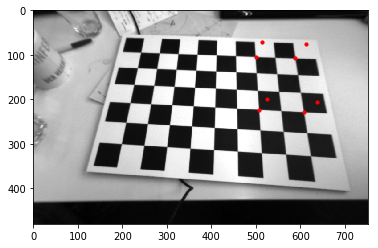

In [6]:
# Define starting coordinates in World Coordinate system (meters) and step size in each direction (meters)
base_x, base_y, base_z = 0.24, 0, 0
delta_x, delta_y, delta_z = 0.08, 0.12, -0.04

# Create cube corners by looping over x,y,z dimensions and create two points for each dimension
us, vs = [], []
for x in range(2):
    for y in range(2):
        for z in range(2):
            # Create a new point
            Pw = makeWorldVector(
                x=base_x+(delta_x*x), 
                y=base_y+(delta_y*y), 
                z=base_z+(delta_z*z)
            )
            # Convert it to uv pixel coordinates and append them to array us, vs
            u, v = worldToPixels(Pw)
            us.append(u)
            vs.append(v)

# Plot results
plotPoints([us], [vs])

To better illustrate the cube, let's hard code some solid lines


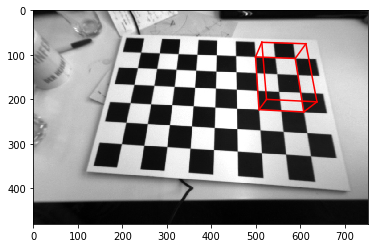

In [7]:
img_plot = plt.imshow(img, cmap='gray')

def drawLine(from_n, to_n):
    """
    Draws a line on the current plot context between two given points
    :param Tuple[int, int] from_n:  (u,v) coordinates of first point
    :param Tuple[int, int] to_n:    (u,v) coordinates of second point
    :return: None
    """
    plt.plot([us[from_n], us[to_n]], [vs[from_n], vs[to_n]], c='r')

drawLine(0, 1)
drawLine(1, 5)
drawLine(5, 4)
drawLine(4, 0)

drawLine(2, 3)
drawLine(3, 7)
drawLine(7, 6)
drawLine(6, 2)

drawLine(0, 2)
drawLine(1, 3)

drawLine(4, 6)
drawLine(5, 7)
    
plt.show()

## Image distortion

As a final step, we take lens disrotion into account. Distortion is usually radial, meaning a pixels distortion depends
on its distance to the origin *O*. The radial distortion can either be positive (Barrel distortion) or negative (pincushion
distortion). In either case, we can describe the distortion with a quadratic model that maps the ideal, non-distorted (u,v)
coordinates from previously to the real, observed coordinates with distortion (ud, vd). 


Since the distortion is depending on the origin, we get the following equation:

![Distortion equation, p. 62]()


The amount of distortion depends on the cameras FoV and a potential misalignment between the Lens and the Optical Sensor. 


## Python implementation

As a more flexible model, we assume independent radial distortion in x and y coordinates.

In our example, we deal with the following distorted image:


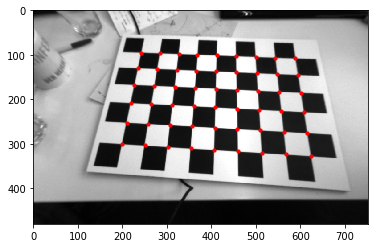

In [8]:
# Load distorted image
img = mpimg.imread('img/chapter_3/img_0001.jpg')[:,:,0]
us, vs = [], []

# Loop over all points on chess board and draw point on image
for x in range(9):
    for y in range(6):
            # Create a new world coordinate vector at corner point of chess board
            Pw = makeWorldVector(
                x=0.04*x, 
                y=0.04*y, 
                z=0
            )
            # Convert it to uv pixel coordinates and append them to array us, vs
            u, v = worldToPixels(Pw)
            us.append(u)
            vs.append(v)

# Plot results
plotPoints([us], [vs])

We can quickly see that we deal with some sort of radial distortion and that our cube would NOT fall correct on this new image, since we have not taken the distortion into account when converting the World coordinates to uv values. 

We happen to know that the distortion factors of our camera is (dist_x, dist_y) = (-0.296609 0.080818). We can therefore, in a first step, fix our mapping functions to take distortion into account. In a second step, we can even undistort the image completely.

As a first step, we write a function that calculatges the new positoin of a point based on the assumed position and a distortion factor D = (dist_x, dist_y)

In [9]:
def undistortPoint(point, D):
    """
    Shifts a point in Camera normalized camera coordinates to new position according to distortion factor D
    :param Tuple[x,y,1] point:  Undistorted point with x,y,1 coordinates in camera frame
    :param Tuple[dx, dy] D:     Distortion factor in x and y direction 
    :return: Distorted point
    :rtype: Tuple[x,y,1]
    """
    dist_x, dist_y = D[0], D[1]
    
    # r^2 = (x^2 + y^2)
    r_squared = point[0] ** 2 + point[1] ** 2
    
    # Calculate undistortion
    point_undistorted = point * (1 + dist_x*r_squared + dist_y*r_squared**2)
    
    # Ensure that last factor is still 1
    point_undistorted[2] = 1
    
    # Return distorted value
    return point_undistorted

The undistortion takes Camera frame coordinates as inputs. So we need to modify our worldToPixels-function to take the distortion into account before calculating discrete pixel values. 

In [10]:
def worldToPixelsDistorted(Pw, D):
    """
    Convers a vector in world coordinates to uv pixel coordinates with taking distortion into account
    :param np.array(x, y, z, 1) Pw:     World vector 
    :param Tuple[dx, dy] D:             Distortion factor in x and y direction 
    :return: (u,v) pixel coordinates of world point in distorted image frame
    :rtype: Tuple[u, v]
    """
    # Project (Xw, Yw, Zw, 0) into cameras coordinate system
    Pc_distorted = np.matmul(T, Pw)
    
    # Normalize by z to get (Xc, Yc, 1)
    Pc_norml = (Pc_distorted / Pc_distorted[2][0])
    
    # Use normalized point to undistort coordinate
    Pc = undistortPoint(Pc_norml, D)
    
    # Project x,y,z to discrete pixel values
    p = np.matmul(K, Pc)
    
    # use first two values since last one is always 1: (u, v, 1). Return u, v
    uv = p[:-1]
    return uv[0], uv[1]

Now use our undistortion function to normalize our chess grid

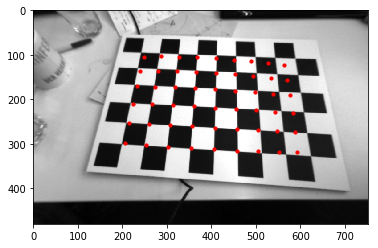

In [11]:
# Lens distortion parameters 2x1
D = np.array([-0.296609, 0.080818])

img = mpimg.imread('img/chapter_3/img_0001.jpg')[:,:,0]
us, vs = [], []

# Create a board of size 9x6
for x in range(9):
    for y in range(6):
            # Create a new world point, each at the base plane with 4m delta in x and y direction
            Pw = makeWorldVector(x=0.04*x, y=0.04*y, z=0)
            # Convert world point to pixel coordinates with taking camera distortion into account
            u, v = worldToPixelsDistorted(Pw, D)
            # Append found coordinates to list so we can plot them later
            us.append(u)
            vs.append(v)

plotPoints([us], [vs])

We see that our disturtion worked - we successfully distorted our point estimations to fit the real image. But let's also try it the other way around: undistort an image such that straight lines are preserved. To do so, we could in theorey invert our mapping function and map each pixel from the distorted image back to the original one. 
Since this would require to invert our mapping function, resulting in a costly polynomial problem, we do it simpler: We loop over the pixels in a blank image and find - for each pixel - the corresponding one in the distorted pixel. 

In [12]:
def undistortImage(img, K, D):
    """
    Undistorts an image based on the distortion D and intrinsics K
    :param np.ndarray[number, number] img:  Input image, greyscale
    :param np.ndarray[float, float] K:      Camera intrinsics
    :param Tuple[dx, dy] D:                 Distortion factor in x and y direction 
    :return: Distortion corrected image img
    :rtype: np.ndarray[number, number]
    """
    undistorted_image = np.zeros(img.shape)
    height, width = undistorted_image.shape[0], undistorted_image.shape[1]

    # Loop over every pixel in our undistorted image
    for y in range(height):
        for x in range(width):
            
            # Convert pixel to normalized coordnates
            normalized_coords = np.linalg.lstsq(K, np.array([x, y, 1]))[0]
            
            # Find counterpart coordinates in distorted image
            distorted_coords = undistortPoint(normalized_coords, D)
            
            # Convert counterpart coordinates back down to pixel values
            pixel_cords = np.matmul(K, distorted_coords)
            
            # Normalize the pixel values
            u = int(pixel_cords[0] / pixel_cords[2])
            v = int(pixel_cords[1] / pixel_cords[2])

            # Check of pixel value exists in distorted image, if it does, write it to the undistorted one
            # at the original position. Else, leave it black as-is
            if (0 <= u < width) and (0 <= v < height):
                undistorted_image[y][x] = img[v][u]
    return undistorted_image

We can now undistort our image before converting the World Coordinates to discretized Pixel Coordinates, which leads to a perfectly looking image without any distortion, implying that we no longer have to undistort our points before drawing them over the image. 

The function above will take quite some time since a linear system of equations has to be solved for each of our pixel. 

c:\users\joelbarmettler\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


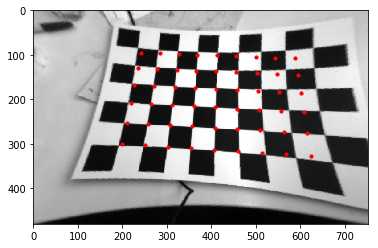

In [13]:
# Lens distortion parameters 2x1
D = np.array([-0.296609, 0.080818])

img = mpimg.imread('img/chapter_3/img_0001.jpg')[:,:,0]
img = undistortImage(img, K, D)
us, vs = [], []

# Create a board of size 9x6
for x in range(9):
    for y in range(6):
        # Create a new world point, each at the base plane with 4m delta in x and y direction
            Pw = makeWorldVector(x=0.04*x, y=0.04*y, z=0)
            # Convert world point to pixel coordinates - there is NO NEED to consider distortion now
            u, v = worldToPixels(Pw)
            # Append found coordinates to list so we can plot them later
            us.append(u)
            vs.append(v)

plotPoints([us], [vs])

## Summary
In this article, we have seen how to do the conversion between the World Coordinate System, the Camera Coordinate System and the Image Frame, even with the presence of a heavy distortion. 

All we need is a definition how the camera stands in respect to the origin, given via T = [R|t], as well as the cameras
intrinsics K and an optional definition of the underlaying distortion D. 

We can then define new points in the world coordinte system in meters and map then onto the correct pixel locations in the output image. 